In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

%matplotlib inline

In [2]:
class VectorQuantizer(nn.Module):
    """
    VQ-VAE layer: Input any tensor to be quantized. 
    Args:
        embedding_dim (int): the dimensionality of the tensors in the
          quantized space. Inputs to the modules must be in this format as well.
        num_embeddings (int): the number of vectors in the quantized space.
        commitment_cost (float): scalar which controls the weighting of the loss terms (see
          equation 4 in the paper - this variable is Beta).
    """
    def __init__(self, embedding_dim, num_embeddings, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # initialize embeddings
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)

    def forward(self, x):
        # [B, C, H, W] -> [B, H, W, C]
        # x = x.permute(0, 2, 1).contiguous()
        # [B, H, W, C] -> [BHW, C]
        flat_x = x.reshape(-1, self.embedding_dim)
        
        encoding_indices = self.get_code_indices(flat_x)
        quantized = self.quantize(encoding_indices)
        quantized = quantized.view_as(x) # [B, H, W, C]
        
        if self.training : 
            # embedding loss: move the embeddings towards the encoder's output
            q_latent_loss = F.mse_loss(quantized, x.detach())
            # commitment loss
            e_latent_loss = F.mse_loss(x, quantized.detach())
            loss = q_latent_loss + self.commitment_cost * e_latent_loss

            # Straight Through Estimator
            quantized = x + (quantized - x).detach()
        
        # quantized = quantized.permute(0, 2, 1).contiguous()
            return quantized, loss
        return quantized

    def get_code_indices(self, flat_x):
        # compute L2 distance
        distances = (
            torch.sum(flat_x ** 2, dim=1, keepdim=True) +
            torch.sum(self.embeddings.weight ** 2, dim=1) -
            2. * torch.matmul(flat_x, self.embeddings.weight.t())
        ) # [N, M]
        encoding_indices = torch.argmin(distances, dim=1) # [N,]
        return encoding_indices
    
    def quantize(self, encoding_indices):
        """Returns embedding tensor for a batch of indices."""
        return self.embeddings(encoding_indices)  

    

In [3]:
class Encoder(nn.Module):
    """The encoder for VAE"""
    
    def __init__(self, input_dim, fc_dim, latent_dim):
        super().__init__()
        
        self.fwd = nn.Sequential(
            nn.Linear(input_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, latent_dim)
        )
                    
    def forward(self, x):
        x = self.fwd(x)
        return x 

class Decoder(nn.Module):
    """The decoder for VAE"""
    
    def __init__(self, latent_dim, fc_dim, output_dim):
        super().__init__()

        self.fwd = nn.Sequential(
            nn.Linear(latent_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.fwd(x)

In [4]:
class VQVAE(nn.Module):
    """VQ-VAE"""
    
    def __init__(self, in_dim, embedding_dim, fc_dim, num_embeddings, data_variance, 
                 commitment_cost=0.25):
        super().__init__()
        self.in_dim = in_dim
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.data_variance = data_variance
        
        self.encoder = Encoder(in_dim,fc_dim, embedding_dim)
        self.vq_layer = VectorQuantizer(embedding_dim, num_embeddings, commitment_cost)
        self.decoder = Decoder(embedding_dim, fc_dim, in_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        if not self.training:
            e = self.vq_layer(z)
            x_recon = self.decoder(e)
            return e, x_recon
        
        e, e_q_loss = self.vq_layer(z)
        x_recon = self.decoder(e)
        
        recon_loss = F.mse_loss(x_recon, x) / self.data_variance
        
        return e_q_loss + recon_loss  

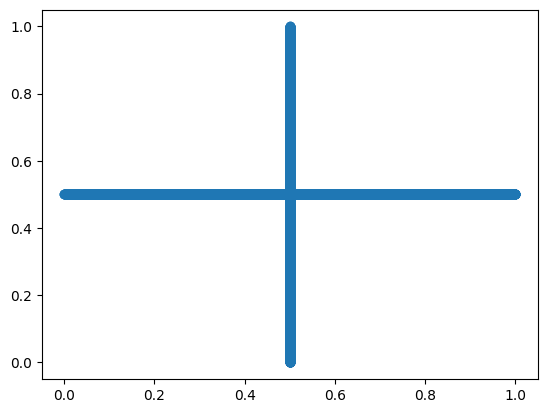

In [5]:
num_points = 10000
filter = lambda x : x # if x>0.55 or x<0.45 else 0.5 + (x>0)*0.05
X1 = [0.5]*num_points
Y1 = [filter(x) for x in torch.rand(num_points)]
X2 = [filter(x) for x in torch.rand(num_points)]
Y2 = [0.5]*num_points
data1 = [(x,y) for x,y in zip(X1,Y1)]
data2 = [(x,y) for x,y in zip(X2,Y2)]
cross_data = data1 + data2

plt.scatter([i[0] for i in cross_data], [i[1] for i in cross_data])

In [6]:
class cross_dataset(torch.utils.data.Dataset) :
    def __init__(self, arr, transforms=None, subset=0) :
        self.arr = arr
        self.transforms = transforms
        if subset>0 : self.arr = self.arr[:subset]
    def __len__(self) :
        return len(self.arr)
    def __getitem__(self, idx) :
        Data = self.arr[idx]
        if self.transforms :
            Data = self.transforms(Data)
        return torch.tensor(Data)


In [9]:
epochs = 4000
embedding_dim = 2 # latent dim
num_embeddings = 128
fc_dim = 15

transform=transforms.Compose([
    transforms.ToTensor(),
])

dataset = cross_dataset(cross_data)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

# compute the variance of the whole training set to normalise the Mean Squared Error below.
train_images = []
for images in train_loader:
    train_images.append(images)
train_images = torch.cat(train_images, dim=0)
train_data_variance = torch.var(train_images)

model = VQVAE(2, embedding_dim, fc_dim, num_embeddings, train_data_variance)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print('params', sum([p.numel() for p in model.parameters()]))


params 890


In [10]:
losslog = []
recons = []
xs = []
for epoch in tqdm(range(epochs)):
    for i, (images) in enumerate(train_loader):
        images = images.to(DEVICE)
        loss = model(images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%300==0 : 
        tqdm.write(f'Epoch {epoch}, loss {loss.item()}')

# optimizer.param_groups[0]['lr'] /= 10
# for epoch in tqdm(range(1200)):
#     for i, (images) in enumerate(train_loader):
#         images = images.to(DEVICE)
#         recon, mu, log_var = model(images)
#         loss = model.compute_loss(images, recon, mu, log_var)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         with torch.no_grad() : losslog.append(loss.item())
#     if epoch%1==0 : 
#         tqdm.write(f'Epoch {epoch}, loss {loss.item()}')

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0, loss 1.0486623048782349
Epoch 300, loss 0.30698493123054504
Epoch 600, loss 0.06569503247737885
Epoch 900, loss 0.019278807565569878
Epoch 1200, loss 0.016095943748950958
Epoch 1500, loss 0.014901617541909218
Epoch 1800, loss 0.01454334706068039
Epoch 2100, loss 0.015141895972192287
Epoch 2400, loss 0.013312535360455513
Epoch 2700, loss 0.011322243139147758
Epoch 3000, loss 0.010377662256360054
Epoch 3300, loss 0.009817419573664665
Epoch 3600, loss 0.008630890399217606
Epoch 3900, loss 0.008937315084040165


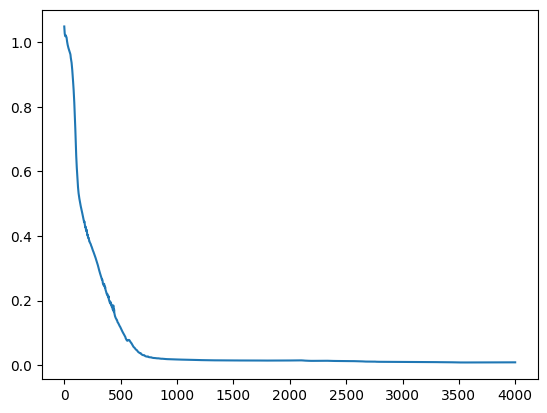

In [11]:
plt.plot(losslog)

In [27]:
# reconstruct images

test_loader_iter = iter(train_loader)
images = next(test_loader_iter)

n_samples = 500
images = images[::len(images)//n_samples]

model.eval() # sets model.training to False

with torch.inference_mode():
    e, recon_images = model(images.to(next(model.parameters()).device))
    recon_images = recon_images.cpu()

(0.0, 1.0)

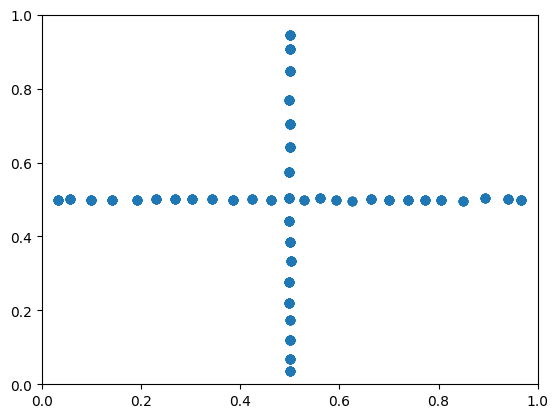

In [28]:
plt.scatter(recon_images[:,0], recon_images[:,1])
plt.xlim(0., 1.)
plt.ylim(0., 1.)

In [36]:
# get encode_indices of training images
for images in train_loader:
    images = images.cuda()
    with torch.inference_mode():
        z = model.encoder(images)
        encoding_indices = model.vq_layer.get_code_indices(z)
        train_indices = encoding_indices.cpu()

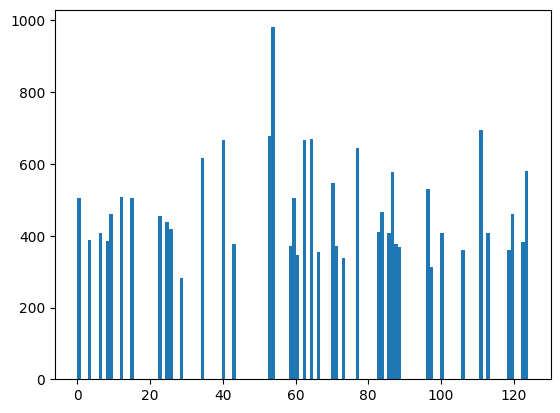

In [43]:
plt.hist(train_indices, bins=128);

In [48]:
F.one_hot(train_indices[0], 128).float()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])